# SDTSIA210 - Machine Learning
## Geoffroy Mateu

# Modules and useful functions

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.io import arff
import pandas as pd
from keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score

Using TensorFlow backend.


In [2]:
#To print the confusion matrix

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes_name=["label 0","label 1"]

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Classification binaire - Données sismiques




## Loading and observation of the data

In [12]:
seismic_data, seismic_metadata = arff.loadarff('Documents/TPT/2A/SDTSIA-210/Projet/Bin_class/seismic-bumps.arff')
display(seismic_metadata)

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [13]:
input_data = pd.DataFrame(seismic_data)
display(input_data.head())

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


It contains binary strings so we need to first clear the data.

### Clearing the data

In [14]:
######################################################################
#              Clear binary strings of the data set                  #
######################################################################
X = input_data.iloc[:,:18]

for stri in ['seismic','seismoacoustic','ghazard']:
    for i in range(len(X[stri])):
        if X[stri][i] == b'a':
            X[stri][i] = 'a'
        if X[stri][i] == b'b':
            X[stri][i] = 'b'
        if X[stri][i] == b'c':
            X[stri][i] = 'c'
        if X[stri][i] == b'd':
            X[stri][i] = 'd'

for i in range(len(X['shift'])):
    if X['shift'][i] == b'N':
        X['shift'][i] = 'N'
    if X['shift'][i] == b'W':
        X['shift'][i] = 'W'

######################################################################
#              Clear binary strings of the label set                 #
######################################################################

input_data['class'] = input_data['class'].map({b'0': 0, b'1': 1})
Y = input_data['class']

######################################################################
#          Preparing set for machine learning algorithms             #
######################################################################

input_data_categorical = X.copy()
cols = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
dummies = pd.get_dummies(input_data_categorical, columns=cols)

print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is",dummies.shape,".")
print("We work with",dummies.shape[0],"data and each one has",dummies.shape[1],"features.")

/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


The shape of the labels is  (2584,) .
The training set consists of labels:  [0 1]
The shape of the observations is (2584, 24) .
We work with 2584 data and each one has 24 features.


/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The data is unbalanced as we can see below.

6.578947368421052 % of the observations have the label 1.
93.42105263157895 % of the observations have the label 0.


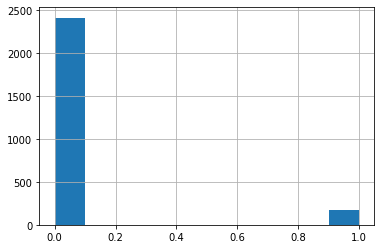

In [15]:

Y.hist()
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

### Scaling the data

By applying this to the dataset, we prevent some features to be more important than others. Since we do not have any infos of how important some features may be regarding others, we normalize everything to make their average equal to 0 with a unit variance.

In [16]:
scaler = StandardScaler()
scaler.fit(dummies)
X_scale = scaler.transform(dummies)
X_scale = pd.DataFrame(X_scale)
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.33, random_state=42)

## 1. First approach using KNN

Knn is a very simple model. We use it to make a first test and see if we can draw some conclusions.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
#We want to test 30 different values for each neighbor
params_knn = {'n_neighbors': np.arange(1, 10)}
#use gridsearch to test all values for n_neighbors (n_jobs = - 1 to enable concurrent programming)
knn_gs = GridSearchCV(knn, params_knn, cv=20)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_


{'n_neighbors': 6}
The best model is:  {'n_neighbors': 6}
This model produces a mean cross-validated score (precision) of 0.9364875701684042
precision on the evaluation set:  0.5
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[0.99748111 0.00251889]
 [0.96610169 0.03389831]]


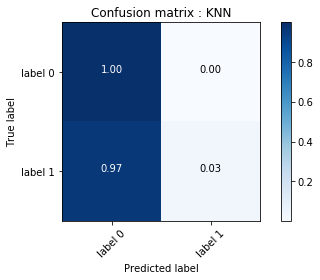

In [18]:
print(knn_gs.best_params_)
print('The best model is: ', knn_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', knn_gs.best_score_)

y_true, y_pred = y_test, knn_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : KNN")
plt.show()

It predicts very poorly class 1 so I am going to look for another method.

## 2. Linear models : SVM


In [19]:
from sklearn.svm import SVC, LinearSVC
tuned_parameters = [{'kernel': ['rbf'], 'class_weight': ['balanced'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'class_weight': ['balanced'] ,'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'class_weight': ['balanced'], 'C': [1, 10, 100, 1000]}]

svc_gs = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=-1, scoring='precision',verbose=1)
svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', ver

In [20]:
from sklearn.svm import SVC, LinearSVC
tuned_parameters = {'C':[0.01,0.1,1,10,100,1000], 'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:15}]}
print(LinearSVC().get_params().keys())
lsvc_gs = GridSearchCV(LinearSVC(), tuned_parameters, cv=5, scoring='precision',verbose=1)
lsvc_gs.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5},
                                          {0: 1, 1: 15}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=1)

{'C': 1, 'class_weight': {0: 1, 1: 5}}
The best model is:  {'C': 1, 'class_weight': {0: 1, 1: 5}}
This model produces a mean cross-validated score (precision) of 0.20903877484522643
precision on the evaluation set:  0.36363636363636365
accuracy on the evaluation set:  0.9097303634232122
Normalized confusion matrix
[[0.94710327 0.05289673]
 [0.59322034 0.40677966]]


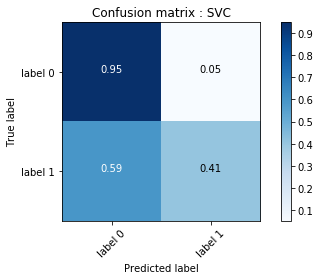

In [21]:
print(lsvc_gs.best_params_)
print('The best model is: ', lsvc_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', lsvc_gs.best_score_)

y_true, y_pred = y_test, lsvc_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : SVC")
plt.show()

Prediction of label 1 is better, but we pay it with a lot of errors of prediction on label 1.

## 2bis. Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
clf.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

precision on the evaluation set:  1.0
accuracy on the evaluation set:  0.9320046893317703
Normalized confusion matrix
[[1.         0.        ]
 [0.98305085 0.01694915]]


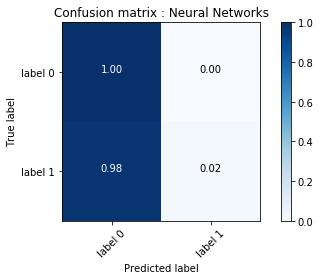

In [23]:

y_true, y_pred = y_test, clf.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()

## 3. Neural Networks

Train on 1731 samples, validate on 853 samples
Epoch 1/30
1731/1731 [==============================] - 0s 116us/step - loss: 0.7967 - accuracy: 0.3374 - val_loss: 0.7340 - val_accuracy: 0.5756
Epoch 2/30
1731/1731 [==============================] - 0s 33us/step - loss: 0.7001 - accuracy: 0.7429 - val_loss: 0.6543 - val_accuracy: 0.8769
Epoch 3/30
1731/1731 [==============================] - 0s 28us/step - loss: 0.6144 - accuracy: 0.9105 - val_loss: 0.5532 - val_accuracy: 0.9203
Epoch 4/30
1731/1731 [==============================] - 0s 29us/step - loss: 0.5112 - accuracy: 0.9301 - val_loss: 0.4508 - val_accuracy: 0.9250
Epoch 5/30
1731/1731 [==============================] - 0s 44us/step - loss: 0.4155 - accuracy: 0.9318 - val_loss: 0.3682 - val_accuracy: 0.9273
Epoch 6/30
1731/1731 [==============================] - 0s 53us/step - loss: 0.3433 - accuracy: 0.9318 - val_loss: 0.3088 - val_accuracy: 0.9273
Epoch 7/30
1731/1731 [==============================] - 0s 56us/step - loss: 0.294

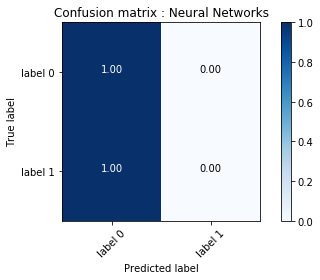

In [24]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation, Flatten
from keras import optimizers
from keras.optimizers import SGD

#Xtrain = preprocessing.scale(X_train)
#Xtest = preprocessing.scale(X_test)

dataset = X_train.copy()
labels = y_train.copy()

input_dim = 24

epochs = 30


model = Sequential()
model.add(Dense(8, activation='relu',input_dim=input_dim))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='adam',
            loss='binary_crossentropy', metrics=['accuracy'])
f = model.fit(dataset,labels,epochs=epochs,batch_size=32, verbose=1, validation_data=(X_test, y_test), shuffle=True)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()


In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=300,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                                               (10, 50),
                                                               (10, 60),
                                 

The best model is:  {'learning_rate': 'constant', 'hidden_layer_sizes': (30,)}
This model produces a mean cross-validated score (precision) of 0.9300961170062134
precision on the evaluation set:  0.45454545454545453
accuracy on the evaluation set:  0.9296600234466589
Normalized confusion matrix
[[0.99244332 0.00755668]
 [0.91525424 0.08474576]]


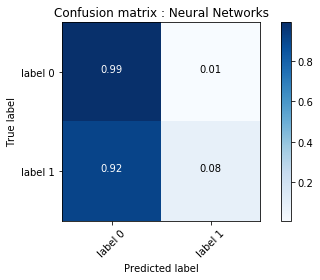

In [26]:
print('The best model is: ', grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', grid.best_score_)

y_true, y_pred = y_test, grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()

## 4. Random Forrest

In [27]:
from sklearn.ensemble import RandomForestClassifier

############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
param_rf = { 
    'n_estimators': [1,20,50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['entropy', 'gini']
}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, param_grid=param_rf, n_jobs=-1, cv=10, verbose=1)

# Fit on training data
modelRF_gs.fit(X_train, y_train)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   51.1s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best model is:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 1}
This model produces a mean cross-validated score (precision) of 0.9358780147498503
precision on the evaluation set:  0.0
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


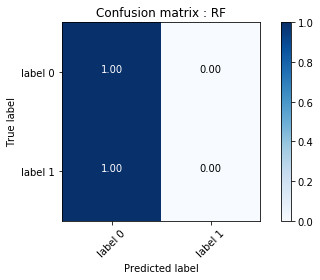

In [28]:
print('The best model is: ', modelRF_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', modelRF_gs.best_score_)

y_true, y_pred = y_test, modelRF_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : RF")
plt.show()

## 5. XGBoost

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1171s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0614s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:    5.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted s

[23:36:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification done in 6.364104270935059s
This model produces a mean cross-validated score (precision) of 0.9358752166377816
precision on the evaluation set:  0.0
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


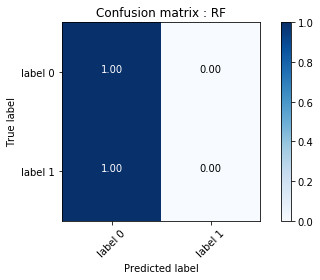

In [29]:
from scipy.stats import uniform, randint
from time import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

t0 = time()
seed = 42
params_fixed={'objective':'binary:logistic','silent':0}
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10,
n_jobs=-1
)
rd_grid.fit(X_train,y_train)

print("Classification done in "+str(time() - t0)+"s")

#print('The best model is: ', rd_grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', rd_grid.best_score_)

y_true, y_pred = y_test, rd_grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : RF")
plt.show()

# Unbalanced output problem

# Up-sampling the '1' class

## Loading and observation of the data

In [3]:
seismic_data, seismic_metadata = arff.loadarff('Documents/TPT/2A/SDTSIA-210/Projet/Bin_class/seismic-bumps.arff')
display(seismic_metadata)

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [4]:
input_data = pd.DataFrame(seismic_data)
display(input_data.head())

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


It contains binary strings so we need to first clear the data.

### Clearing the data

In [5]:
######################################################################
#              Clear binary strings of the data set                  #
######################################################################

for stri in ['seismic','seismoacoustic','ghazard']:
    for i in range(len(input_data[stri])):
        if input_data[stri][i] == b'a':
            input_data[stri][i] = 'a'
        if input_data[stri][i] == b'b':
            input_data[stri][i] = 'b'
        if input_data[stri][i] == b'c':
            input_data[stri][i] = 'c'
        if input_data[stri][i] == b'd':
            input_data[stri][i] = 'd'

for i in range(len(input_data['shift'])):
    if input_data['shift'][i] == b'N':
        input_data['shift'][i] = 'N'
    if input_data['shift'][i] == b'W':
        input_data['shift'][i] = 'W'
######################################################################
#              Clear binary strings of the label set                 #
######################################################################

input_data['class'] = input_data['class'].map({b'0': 0, b'1': 1})

from sklearn.utils import resample

#separate 0 and 1 classes
data_majority = input_data[input_data['class'] == 0]
data_minority = input_data[input_data['class'] == 1]

zero_samples = int(data_majority.shape[0] / 2 )

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=zero_samples,    # to match majority class
                                 random_state=123) # reproducible results

dataProcessed_balanced = pd.concat([data_majority, data_minority_upsampled])

X = dataProcessed_balanced.iloc[:,:18]
Y = dataProcessed_balanced['class']


######################################################################
#          Preparing set for machine learning algorithms             #
######################################################################
input_data_categorical = X.copy()
cols = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
dummies = pd.get_dummies(input_data_categorical, columns=cols)

print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is",dummies.shape,".")
print("We work with",dummies.shape[0],"data and each one has",dummies.shape[1],"features.")


/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

The shape of the labels is  (3621,) .
The training set consists of labels:  [0 1]
The shape of the observations is (3621, 24) .
We work with 3621 data and each one has 24 features.


The data is unbalanced as we can see below.

33.33333333333333 % of the observations have the label 1.
66.66666666666667 % of the observations have the label 0.


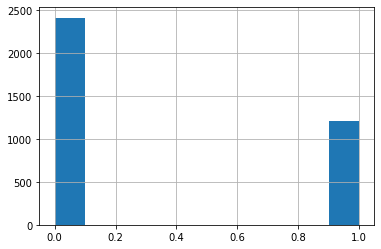

In [6]:

Y.hist()
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

### Scaling the data

By applying this to the dataset, we prevent some features to be more important than others. Since we do not have any infos of how important some features may be regarding others, we normalize everything to make their average equal to 0 with a unit variance.

In [7]:
scaler = StandardScaler()
scaler.fit(dummies)
X_scale = scaler.transform(dummies)
X_scale = pd.DataFrame(X_scale)
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.33, random_state=42)

ValueError: ignored

## 4. Random Forrest

In [14]:
from sklearn.ensemble import RandomForestClassifier

############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
param_rf = { 
    'n_estimators': [1,20,50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['entropy', 'gini']
}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, param_grid=param_rf, n_jobs=-1, cv=10, verbose=1)

# Fit on training data
modelRF_gs.fit(X_train, y_train)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   57.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

The best model is:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
This model produces a mean cross-validated score (precision) of 0.7819576233717647
precision on the evaluation set:  0.6713483146067416
accuracy on the evaluation set:  0.7690376569037657
Normalized confusion matrix
[[0.8531995  0.1468005 ]
 [0.39949749 0.60050251]]


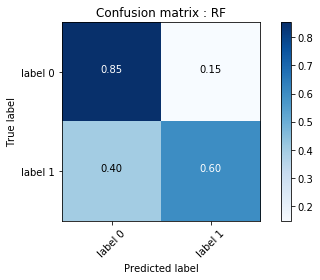

In [15]:
print('The best model is: ', modelRF_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', modelRF_gs.best_score_)

y_true, y_pred = y_test, modelRF_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : RF")
plt.show()

## 5. XGBoost

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1051s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1037s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   10.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.5s finished


[01:24:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification done in 11.701741218566895s
This model produces a mean cross-validated score (precision) of 0.9497148416943054
precision on the evaluation set:  0.9205607476635514
accuracy on the evaluation set:  0.9682008368200837
Normalized confusion matrix
[[0.95734003 0.04265997]
 [0.01005025 0.98994975]]


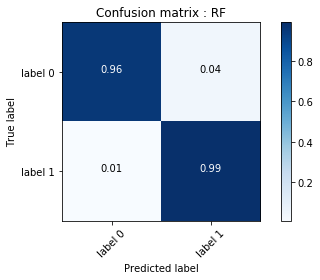

In [16]:
from scipy.stats import uniform, randint
from time import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

t0 = time()
seed = 42
params_fixed={'objective':'binary:logistic','silent':0}
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10,
n_jobs=-1
)
rd_grid.fit(X_train,y_train)

print("Classification done in "+str(time() - t0)+"s")

#print('The best model is: ', rd_grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', rd_grid.best_score_)

y_true, y_pred = y_test, rd_grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : XGBoost")
plt.show()

## 3. Neural Networks

Train on 2426 samples, validate on 1195 samples
Epoch 1/30
2426/2426 [==============================] - 0s 85us/step - loss: 0.6614 - accuracy: 0.6566 - val_loss: 0.6317 - val_accuracy: 0.7096
Epoch 2/30
2426/2426 [==============================] - 0s 34us/step - loss: 0.6089 - accuracy: 0.7135 - val_loss: 0.5814 - val_accuracy: 0.7247
Epoch 3/30
2426/2426 [==============================] - 0s 33us/step - loss: 0.5672 - accuracy: 0.7214 - val_loss: 0.5573 - val_accuracy: 0.7238
Epoch 4/30
2426/2426 [==============================] - 0s 33us/step - loss: 0.5456 - accuracy: 0.7292 - val_loss: 0.5409 - val_accuracy: 0.7372
Epoch 5/30
2426/2426 [==============================] - 0s 40us/step - loss: 0.5301 - accuracy: 0.7424 - val_loss: 0.5309 - val_accuracy: 0.7414
Epoch 6/30
2426/2426 [==============================] - 0s 37us/step - loss: 0.5204 - accuracy: 0.7556 - val_loss: 0.5252 - val_accuracy: 0.7448
Epoch 7/30
2426/2426 [==============================] - 0s 36us/step - loss: 0.514

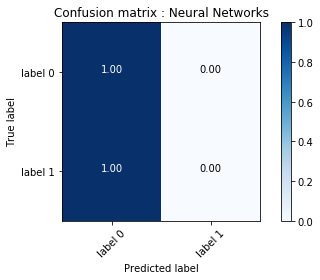

In [13]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation, Flatten
from keras import optimizers
from keras.optimizers import SGD

#Xtrain = preprocessing.scale(X_train)
#Xtest = preprocessing.scale(X_test)

dataset = X_train.copy()
labels = y_train.copy()

input_dim = 24

epochs = 30


model = Sequential()
model.add(Dense(8, activation='relu',input_dim=input_dim))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='adam',
            loss='binary_crossentropy', metrics=['accuracy'])
f = model.fit(dataset,labels,epochs=epochs,batch_size=32, verbose=1, validation_data=(X_test, y_test), shuffle=True)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=300,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                                               (10, 50),
                                                               (10, 60),
                                 

The best model is:  {'learning_rate': 'constant', 'hidden_layer_sizes': (190, 80)}
This model produces a mean cross-validated score (precision) of 0.9212786899155742
precision on the evaluation set:  0.8073593073593074
accuracy on the evaluation set:  0.9046025104602511
Normalized confusion matrix
[[0.88833124 0.11166876]
 [0.06281407 0.93718593]]


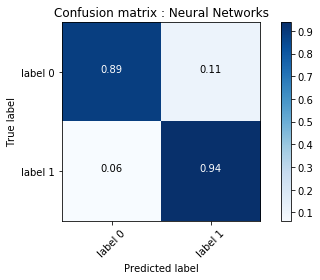

In [12]:
print('The best model is: ', grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', grid.best_score_)

y_true, y_pred = y_test, grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()